# Rare Variant Analysis

In this notebook, I'm going to analyze the rare variants identified
in the Rare Variant Processing notebook.

In [1]:
import copy
import cPickle
import datetime as dt
import glob
import os
import re
import subprocess
import urllib2

import cdpybio as cpb
from ipyparallel import Client
from scipy.stats import fisher_exact
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyencodetools as pet
import pybedtools as pbt
import scipy
import scipy.stats as stats
import seaborn as sns
import socket
import statsmodels.stats.multitest as smm
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'rare_variant_analysis'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
sns.set_style('whitegrid')

In [3]:
tg = pd.read_table(cpy.gencode_transcript_gene, index_col=0, 
                   header=None, squeeze=True)
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
genes = pbt.BedTool(cpy.gencode_gene_bed)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)

cnvs = pd.read_table(os.path.join(ciepy.root, 'output', 'input_data',
                                  'cnvs.tsv'), index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0, squeeze=True)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
rna_meta_eqtl = rna_meta[rna_meta.in_eqtl]
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)

rna_meta = rna_meta.merge(subject_meta, left_on='subject_id', right_index=True)

fn = os.path.join(os.path.split(cpy.roadmap_15_state_annotation)[0], 'EIDlegend.txt')
roadmap_ids = pd.read_table(fn, squeeze=True, index_col=0, header=None)

In [4]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_major_allele_freq.tsv')
maj_af = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_p_val_ase.tsv')
ase_pval = pd.read_table(fn, index_col=0)

locus_p = pd.Panel({'major_allele_freq':maj_af, 'p_val_ase':ase_pval})
locus_p = locus_p.swapaxes(0, 2)

In [5]:
fn = os.path.join(ciepy.root, 'private_output', 
                  'rare_variant_processing', 'rare_variants.pickle')
rare_vars = cPickle.load(open(fn))
fn = os.path.join(ciepy.root, 'private_output', 
                  'rare_variant_processing', 'rare_variant_genotypes.tsv')
rare_var_genotypes = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 
                  'rare_variant_processing', 'tf_disruption.tsv')
tf_disruption = pd.read_table(fn, index_col=0)

In [6]:
t = pd.DataFrame({'position':tf_disruption[tf_disruption.sum(axis=1) > 0].index,
                  'tf_disrupt':True})
rare_vars = rare_vars.merge(t, how='outer')
rare_vars.ix[rare_vars.tf_disrupt.isnull(), 'tf_disrupt'] = False
rare_vars.index = rare_vars.position

In [7]:
unrelateds = list(rna_meta_eqtl.ix[rna_meta_eqtl.in_unrelateds, 'wgs_id'])
log_tpm = np.log10(tpm + 1)

In [8]:
# Create expression and genotype dataframes for unrelated individuals.
rare_var_genotypes_f = rare_var_genotypes[unrelateds]
log_tpm_f = log_tpm[rna_meta[rna_meta.in_unrelateds].index]
log_tpm_f.columns = rna_meta.ix[rna_meta.in_unrelateds, 'wgs_id']
log_tpm_f = log_tpm_f[(log_tpm_f > np.log10(2)).sum(axis=1) >= 10]
log_tpm_c = (log_tpm_f.T - log_tpm_f.mean(axis=1)).T
log_tpm_z = (log_tpm_c.T / log_tpm_c.std(axis=1)).T
ase_pval_f = ase_pval[rna_meta[rna_meta.in_unrelateds].index]
ase_pval_f.columns = rna_meta[rna_meta.in_unrelateds].wgs_id

This next step takes a few minutes to run.

In [ ]:
rare_ind = []
rare = {}
for k in ['zscore', 'sample', 'position', 'tf_disrupt', 'ase_pval']:
    rare[k] = []
not_rare_ind = []
not_rare = {}
for k in ['zscore', 'sample', 'position', 'ase_pval']:
    not_rare[k] = []

for i,ind in enumerate(rare_vars.index):
#     if i % 1000 == 0:
#         print(i)
    se = rare_var_genotypes_f.ix[ind]
    rare_samples = se[se != 0].index
    not_rare_samples = se[se == 0].index
    genes = rare_vars.ix[ind, 'genes']
    for g in genes:
        if g in log_tpm_z.index:
            rare['zscore'] += list(log_tpm_z.ix[g, rare_samples])
            rare['sample'] += list(rare_samples)
            rare['position'] += [ind for i in range(len(rare_samples))]
            rare['tf_disrupt'] += [rare_vars.ix[ind, 'tf_disrupt'] for i in range(len(rare_samples))]
            if g in ase_pval_f.index:
                rare['ase_pval'] += list(ase_pval_f.ix[g, rare_samples])
            else:
                rare['ase_pval'] += [np.nan for i in range(len(rare_samples))]
            rare_ind += ['{}:{}'.format(ind, x) for x in rare_samples]
            
            not_rare['zscore'] += list(log_tpm_z.ix[g, not_rare_samples])
            not_rare['sample'] += list(not_rare_samples)
            not_rare['position'] += [ind for i in range(len(not_rare_samples))]
            if g in ase_pval_f.index:
                not_rare['ase_pval'] += list(ase_pval_f.ix[g, not_rare_samples])
            else:
                not_rare['ase_pval'] += [np.nan for i in range(len(not_rare_samples))]
            not_rare_ind += ['{}:{}'.format(ind, x) for x in not_rare_samples]
rare_info = pd.DataFrame(rare, index=rare_ind)
not_rare_info = pd.DataFrame(not_rare, index=not_rare_ind)

In [11]:
r = sum(rare_info.ase_pval.dropna() < 0.005) / float(rare_info.ase_pval.dropna().shape[0])
nr = sum(not_rare_info.ase_pval.dropna() < 0.005) / float(not_rare_info.ase_pval.dropna().shape[0])
a = (rare_info.ase_pval.dropna() < 0.005).value_counts()
b = (not_rare_info.ase_pval.dropna() < 0.005).value_counts()
odds, p = stats.fisher_exact([[a[True], a[False]], [b[True], b[False]]])
print('Gene/samples with rare promoter DHS variant have ASE {:.2f}% of the '
      'time while gene/samples without rare promoter DHS variant have ASE '
      '{:.2f}% of the time (odds={:.2f}, p={:.2e}, Fisher exact).'.format(r * 100, nr * 100, odds, p))

Gene/samples with rare promoter DHS variant have ASE 3.29% of the time while gene/samples without rare promoter DHS variant have ASE 2.85% of the time (odds=1.16, p=6.55e-06, Fisher exact).


Gene/sample pairs with a rare DHS promoter variant are enriched for ASE.

In [12]:
s,p = stats.mannwhitneyu(rare_info.zscore, not_rare_info.zscore)
print('The distributions of z-score expression values for genes with and without '
      'rare promoter DHS variants is significantly different (Mann-Whitney U, p={:.2e}).'.format(p))

The distributions of z-score expression values for genes with and without rare promoter DHS variants is significantly different (Mann-Whitney U, p=3.86e-83).


In [13]:
s,p = stats.mannwhitneyu(rare_info.zscore.abs(), not_rare_info.zscore.abs())
print('The distributions of z-score expression magnitudes for genes with and without '
      'rare promoter DHS variants is significantly different (Mann-Whitney U, p={:.2e}).'.format(p))

The distributions of z-score expression magnitudes for genes with and without rare promoter DHS variants is significantly different (Mann-Whitney U, p=1.64e-63).


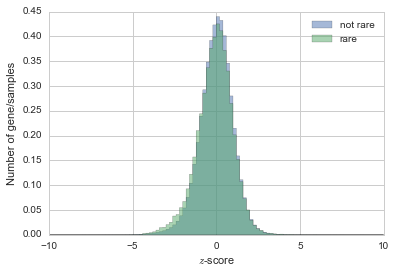

In [14]:
not_rare_info.zscore.hist(normed=True, bins=np.arange(-10, 10.2, 0.2), 
                          alpha=0.5, histtype='stepfilled', label='not rare')
rare_info.zscore.hist(normed=True, bins=np.arange(-10, 10.2, 0.2), 
                      alpha=0.5, histtype='stepfilled', label='rare')
plt.legend()
plt.xlabel('$z$-score')
plt.ylabel('Number of gene/samples');

In [15]:
pdfs = pd.DataFrame(index=np.arange(-10, 10.1, 0.1))
density = scipy.stats.gaussian_kde(rare_info.zscore)
pdfs['rare'] = density(pdfs.index)
density = scipy.stats.gaussian_kde(not_rare_info.zscore)
pdfs['not_rare'] = density(pdfs.index)

In [16]:
density = scipy.stats.gaussian_kde(rare_info[rare_info.tf_disrupt].zscore)
pdfs['rare_tf_disrupt'] = density(pdfs.index)
density = scipy.stats.gaussian_kde(rare_info[rare_info.tf_disrupt == False].zscore)
pdfs['rare_not_tf_disrupt'] = density(pdfs.index)

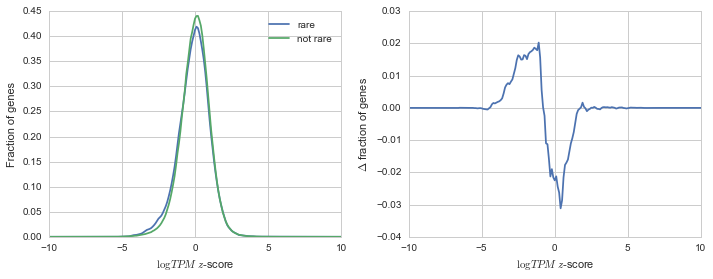

In [17]:
fig,axs = plt.subplots(1, 2, figsize=(10, 4))
ax = axs[0]

pdfs.rare.plot(label='rare', ax=ax)
pdfs.not_rare.plot(label='not rare', ax=ax)
ax.legend()
ax.set_ylabel('Fraction of genes')
ax.set_xlabel('$\log TPM$ $z$-score')
ax = axs[1]
(pdfs.rare - pdfs.not_rare).plot(ax=ax)
ax.set_ylabel('$\Delta$ fraction of genes')
ax.set_xlabel('$\log TPM$ $z$-score')
fig.tight_layout()
fig.savefig(os.path.join(outdir, 'rare_var_effect.pdf'))

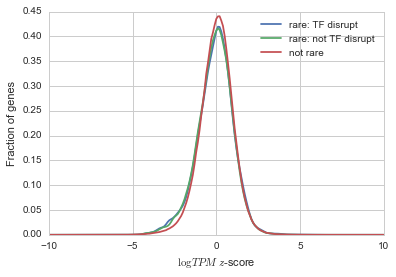

In [18]:
pdfs.rare_tf_disrupt.plot(label='rare: TF disrupt')
pdfs.rare_not_tf_disrupt.plot(label='rare: not TF disrupt')
pdfs.not_rare.plot(label='not rare')
plt.legend()
plt.ylabel('Fraction of genes')
plt.xlabel('$\log TPM$ $z$-score');

In [19]:
cdfs = pd.DataFrame(index=pdfs.index)
area = [0]
for i in range(1, cdfs.shape[0]):
    area.append(0.5 * (pdfs['rare'].loc[pdfs.index[i - 1]] + pdfs['rare'][pdfs.index[i]]) * 0.1)
cdfs['rare'] = pd.Series(area, index=cdfs.index).cumsum()
area = [0]
for i in range(1, cdfs.shape[0]):
    area.append(0.5 * (pdfs['not_rare'].loc[pdfs.index[i - 1]] + pdfs['not_rare'][pdfs.index[i]]) * 0.1)
cdfs['not_rare'] = pd.Series(area, index=cdfs.index).cumsum()

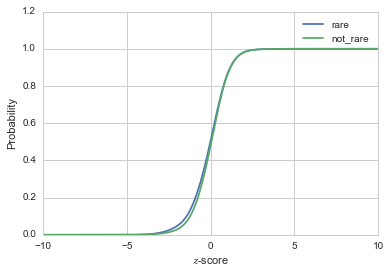

In [20]:
cdfs.plot()
plt.xlabel('$z$-score')
plt.ylabel('Probability');

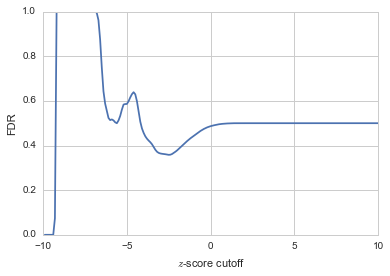

In [21]:
fdr = cdfs.not_rare / (cdfs.sum(axis=1))
fdr.plot()
plt.ylabel('FDR')
plt.xlabel('$z$-score cutoff');

In [39]:
m = fdr[fdr > 0.2].min()
i = fdr[fdr == m].index[0]
fnc_rare_vars = rare_info[rare_info.zscore <= i]
print('The minimum FDR occurs at z={} and is {:.1f}%.'.format(i, m * 100))
print('{:,} of {:,} rare variants have z < {}'.format(fnc_rare_vars.shape[0], rare_info.shape[0], i))

The minimum FDR occurs at z=-2.5 and is 35.8%.
1,706 of 70,361 rare variants have z < -2.5


In [50]:
frd = fnc_rare_vars.tf_disrupt.sum()
frnd = fnc_rare_vars.shape[0] - frd
rd = rare_info.drop(fnc_rare_vars.index).tf_disrupt.sum()
rnd = rare_info.drop(fnc_rare_vars.index).shape[0] - rd
odds, p = stats.fisher_exact([[frd, frnd], [rd, rnd]])
print('Predicted functional rare variants are slightly enriched for '
      'disruping TF binding sites compared to rare variants not predicted '
      'to be functional: odds={:.3f}, p={:.3f}'.format(odds, p))

Predicted functional rare variants are slightly enriched for disruping TF binding sites compared to rare variants not predicted to be functional: odds=1.152, p=0.011


In [70]:
frid = rare_vars.ix[fnc_rare_vars.position, 'indel'].value_counts()[True]
frnid = rare_vars.ix[fnc_rare_vars.position, 'indel'].value_counts()[False]
rid = rare_vars.ix[rare_info.drop(fnc_rare_vars.index).position, 'indel'].value_counts()[True]
rnid = rare_vars.ix[rare_info.drop(fnc_rare_vars.index).position, 'indel'].value_counts()[False]
odds, p = stats.fisher_exact([[frid, frnid], [rid, rnid]])
print('Predicted functional rare variants are not enriched for '
      'being indels compared to rare variants not predicted '
      'to be functional: odds={:.3f}, p={:.3f}'.format(odds, p))

Predicted functional rare variants are not enriched for being indels compared to rare variants not predicted to be functional: odds=1.069, p=0.488


In [96]:
s,p = stats.mannwhitneyu(rare_vars.ix[fnc_rare_vars.position, 'conservation'],
                         rare_vars.ix[rare_info.drop(fnc_rare_vars.index).position, 'conservation'])
print('Predicted functional do not have significantly different '
      'conservation scores compared to rare variants not predicted '
      'to be functional: p={:.3f}'.format(p))

Predicted functional do not have significantly different conservation scores compared to rare variants not predicted to be functional: p=0.324


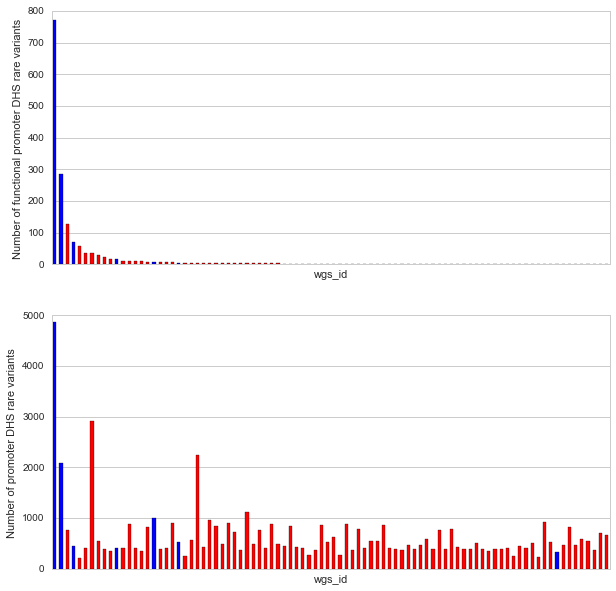

In [140]:
wgs_info = wgs_meta.join(fnc_rare_vars['sample'].value_counts()).dropna()
wgs_info.columns = ['cell', 'subject_id', 'num_fnc_rare_vars']
wgs_info = wgs_info.join(rare_info['sample'].value_counts()).dropna()
wgs_info.columns = ['cell', 'subject_id', 'num_fnc_rare_vars', 'num_rare_vars']
wgs_info = wgs_info.sort_values(by='num_fnc_rare_vars', ascending=False)
wgs_info = wgs_info.merge(subject_meta, left_on='subject_id', right_index=True)
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
ax = axs[0]
ax= wgs_info.num_fnc_rare_vars.plot(kind='bar', ax=ax,
                                    color=[{'Fibroblast':'blue', 'Blood':'red'}[x] for x in wgs_info.cell])
ax.set_ylabel('Number of functional promoter DHS rare variants');
ax.set_xticks([])
ax = axs[1]
ax= wgs_info.num_rare_vars.plot(kind='bar', ax=ax,
                                color=[{'Fibroblast':'blue', 'Blood':'red'}[x] for x in wgs_info.cell])
ax.set_ylabel('Number of promoter DHS rare variants');
ax.set_xticks([]);

In [169]:
wgs_info['log_num_rare_vars'] = np.log10(wgs_info.num_rare_vars)
wgs_info['log_num_fnc_rare_vars'] = np.log10(wgs_info.num_fnc_rare_vars)

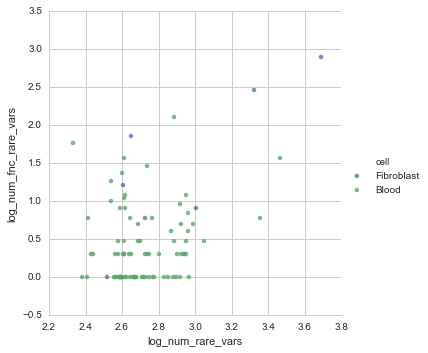

In [170]:
sns.lmplot(x='log_num_rare_vars', y='log_num_fnc_rare_vars', data=wgs_info,
           logx=True, hue='cell', fit_reg=False);

In [173]:
wgs_info.ethnicity_group.value_counts()

European                         61
Asian                            14
Multiple ethnicities reported     5
Hispanic                          5
African American                  2
Indian                            2
Middle Eastern                    1
Name: ethnicity_group, dtype: int64

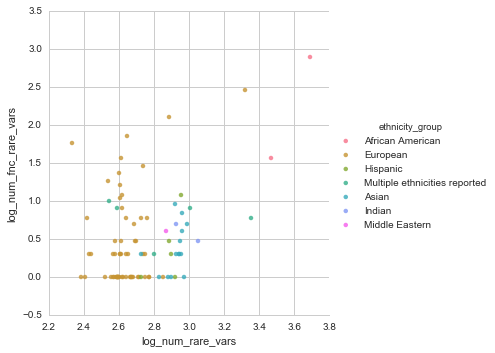

In [171]:
sns.lmplot(x='log_num_rare_vars', y='log_num_fnc_rare_vars', data=wgs_info,
           logx=True, hue='ethnicity_group', fit_reg=False);

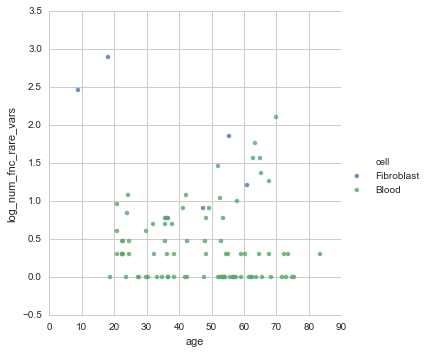

In [172]:
sns.lmplot(x='age', y='log_num_fnc_rare_vars', data=wgs_info,
           logx=True, hue='cell', fit_reg=False);

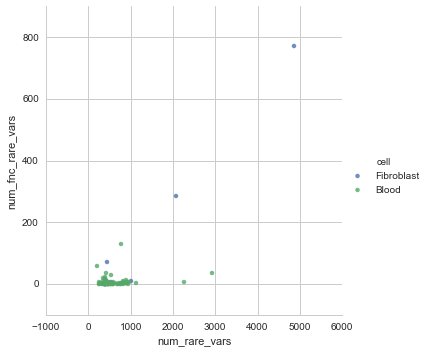

In [155]:
sns.lmplot(x='num_rare_vars', y='num_fnc_rare_vars', data=wgs_info,
           logx=True, hue='cell', fit_reg=False);

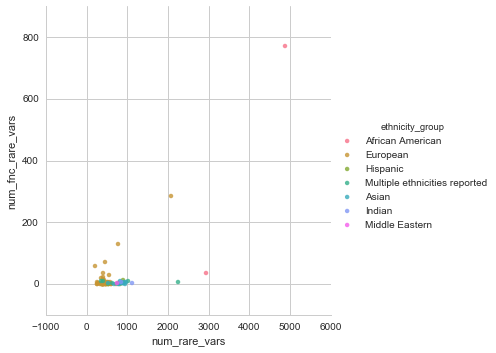

In [167]:
sns.lmplot(x='num_rare_vars', y='num_fnc_rare_vars', data=wgs_info,
           logx=True, hue='ethnicity_group', fit_reg=False);

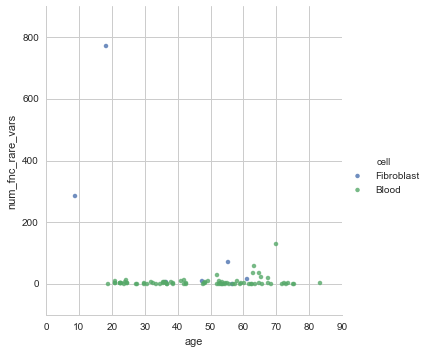

In [168]:
sns.lmplot(x='age', y='num_fnc_rare_vars', data=wgs_info,
           logx=True, hue='cell', fit_reg=False);

Distance to TSS? ASE?

## Rare CNVs

In [ ]:
fn = os.path.join(ciepy.root, 'output/cnv_processing/cnv_info.tsv')
cnv_info = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'private_output/cnv_processing/cnv_genotypes.tsv')
cnv_geno = pd.read_table(fn, index_col=0)

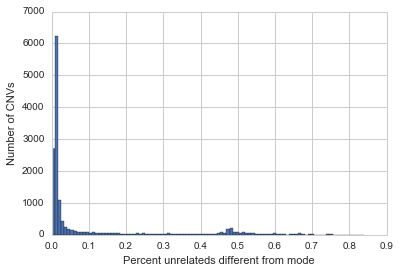

In [ ]:
cnv_info.unrelated_percent_diff_from_mode.hist(bins=100)
plt.ylabel('Number of CNVs')
plt.xlabel('Percent unrelateds different from mode');

In [ ]:
cnv_info.sort_values(by='unrelated_diff_from_mode', inplace=True)

In [ ]:
rare_cnv_info = cnv_info[cnv_info.unrelated_diff_from_mode == 1]
rare_cnv_info = rare_cnv_info.dropna(subset=['gene_overlaps'])

In [ ]:
lessr = []
for i in rare_cnv_info.index:
    se = cnv_geno.ix[i, unrelateds]
    mode = rare_cnv_info.ix[i, 'cn_mode']
    if sum(se < mode) > 0:
        lessr.append(se[se < mode])
rare_cnv_less = pd.DataFrame(lessr)
rare_cnv_less.to_csv(os.path.join(private_outdir, 'rare_cnv_less.tsv'), sep='\t')

In [ ]:
cnv_rare = []
cnv_rare_ase_pval = []
cnv_rare_less = []
cnv_rare_greater = []
cnv_not_rare = []
cnv_not_rare_ase_pval = []
for i in rare_cnv_info.index:
    se = cnv_geno.ix[i, unrelateds]
    mode = rare_cnv_info.ix[i, 'cn_mode']
    r = se[se != mode].index
    lessr = se[se < mode]
    greaterr = se[se > mode]
    nr = se[se == mode].index
    for g in set(rare_cnv_info.ix[i, 'gene_overlaps'].split(',')) & set(log_tpm_z.index):
        cnv_rare += list(log_tpm_z.ix[g, r])
        cnv_rare_less += list(log_tpm_z.ix[g, lessr])
        cnv_rare_greater += list(log_tpm_z.ix[g, greaterr])
        cnv_not_rare += list(log_tpm_z.ix[g, nr])
        if g in ase_pval.index:
            cnv_rare_ase_pval += list(ase_pval_f.ix[g, r])
            cnv_not_rare_ase_pval += list(ase_pval_f.ix[g, nr])
cnv_rare = pd.Series(cnv_rare)
cnv_rare_ase_pval = pd.Series(cnv_rare_ase_pval).dropna()
cnv_not_rare = pd.Series(cnv_not_rare)
cnv_rare_less = pd.Series(cnv_rare_less)
cnv_rare_greater = pd.Series(cnv_rare_greater)
cnv_not_rare_ase_pval = pd.Series(cnv_not_rare_ase_pval).dropna()

In [ ]:
r = sum(cnv_rare_ase_pval < 0.005) / float(cnv_rare_ase_pval.shape[0])
nr = sum(cnv_not_rare_ase_pval < 0.005) / float(cnv_not_rare_ase_pval.shape[0])
a = (cnv_rare_ase_pval < 0.005).value_counts()
b = (cnv_not_rare_ase_pval < 0.005).value_counts()
odds, p = stats.fisher_exact([[a[True], a[False]], [b[True], b[False]]])
print('Gene/samples with rare genic CNV have ASE {:.2f}% of the '
      'time while gene/samples without rare promoter DHS variant have ASE '
      '{:.2f}% of the time (odds={:.2f}, p={:.2e}, Fisher exact).'.format(r * 100, nr * 100, odds, p))

Gene/samples with rare genic CNV have ASE 8.04% of the time while gene/samples without rare promoter DHS variant have ASE 3.12% of the time (odds=2.72, p=9.73e-13, Fisher exact).


In [ ]:
s,p = stats.mannwhitneyu(cnv_rare, cnv_not_rare)
print('The distributions of z-score expression values for genes with and without '
      'rare genic CNVs is significantly different (Mann-Whitney U, p={:.2e}).'.format(p))

The distributions of z-score expression values for genes with and without rare genic CNVs is significantly different (Mann-Whitney U, p=8.41e-08).


In [ ]:
s,p = stats.mannwhitneyu(cnv_rare.abs(), cnv_not_rare.abs())
print('The distributions of z-score expression magnitudes for genes with and without '
      'rare genic CNVs is significantly different (Mann-Whitney U, p={:.2e}).'.format(p))

The distributions of z-score expression magnitudes for genes with and without rare genic CNVs is significantly different (Mann-Whitney U, p=1.56e-18).


In [ ]:
print(stats.mannwhitneyu(cnv_rare_less, cnv_not_rare))
print(stats.mannwhitneyu(cnv_rare_less.abs(), cnv_not_rare.abs()))

MannwhitneyuResult(statistic=244274758.0, pvalue=0.26920546044906934)
MannwhitneyuResult(statistic=195411157.0, pvalue=8.539737391520741e-53)


In [ ]:
print(stats.mannwhitneyu(cnv_rare_greater, cnv_not_rare))
print(stats.mannwhitneyu(cnv_rare_greater.abs(), cnv_not_rare.abs()))

MannwhitneyuResult(statistic=48318389.0, pvalue=3.2154123707138734e-22)
MannwhitneyuResult(statistic=52732573.0, pvalue=9.762408868882238e-13)


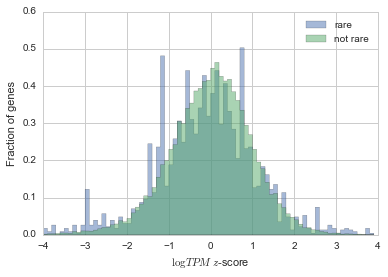

In [ ]:
cnv_rare.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='rare')
cnv_not_rare.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='not rare')
plt.legend()
plt.ylabel('Fraction of genes')
plt.xlabel('$\log TPM$ $z$-score');

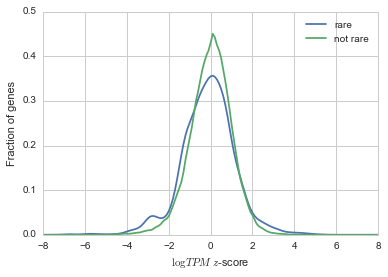

In [ ]:
xs = np.arange(-8, 8.1, 0.1)
density = scipy.stats.gaussian_kde(cnv_rare)
y_rare = density(xs)
density = scipy.stats.gaussian_kde(cnv_not_rare)
y_not_rare = density(xs)
y_rare = pd.Series(y_rare, index=xs)
y_not_rare = pd.Series(y_not_rare, index=xs)
y_rare.plot(label='rare')
y_not_rare.plot(label='not rare')
plt.legend()
plt.ylabel('Fraction of genes')
plt.xlabel('$\log TPM$ $z$-score');

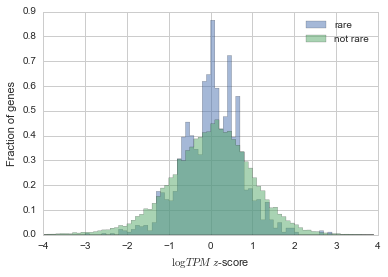

In [ ]:
cnv_rare_less.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='rare')
cnv_not_rare.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='not rare')
plt.legend()
plt.ylabel('Fraction of genes')
plt.xlabel('$\log TPM$ $z$-score');

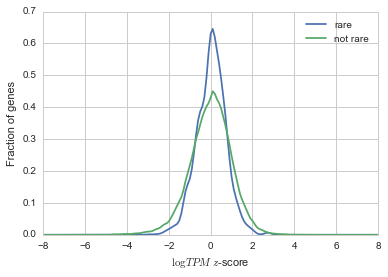

In [ ]:
xs = np.arange(-8, 8.1, 0.1)
density = scipy.stats.gaussian_kde(cnv_rare_less)
y_rare = density(xs)
density = scipy.stats.gaussian_kde(cnv_not_rare)
y_not_rare = density(xs)
y_rare = pd.Series(y_rare, index=xs)
y_not_rare = pd.Series(y_not_rare, index=xs)
y_rare.plot(label='rare')
y_not_rare.plot(label='not rare')
plt.legend()
plt.ylabel('Fraction of genes')
plt.xlabel('$\log TPM$ $z$-score');

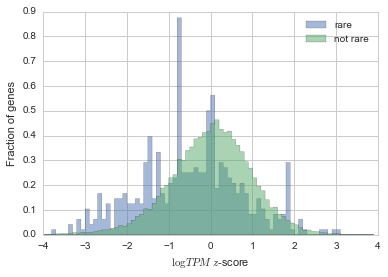

In [ ]:
cnv_rare_greater.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='rare')
cnv_not_rare.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='not rare')
plt.legend()
plt.ylabel('Fraction of genes')
plt.xlabel('$\log TPM$ $z$-score');

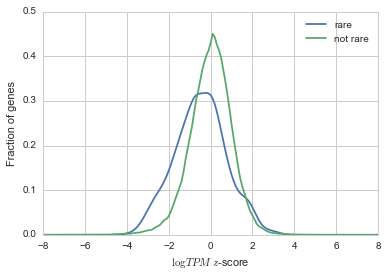

In [ ]:
xs = np.arange(-8, 8.1, 0.1)
density = scipy.stats.gaussian_kde(cnv_rare_greater)
y_rare = density(xs)
density = scipy.stats.gaussian_kde(cnv_not_rare)
y_not_rare = density(xs)
y_rare = pd.Series(y_rare, index=xs)
y_not_rare = pd.Series(y_not_rare, index=xs)
y_rare.plot(label='rare')
y_not_rare.plot(label='not rare')
plt.legend()
plt.ylabel('Fraction of genes')
plt.xlabel('$\log TPM$ $z$-score');

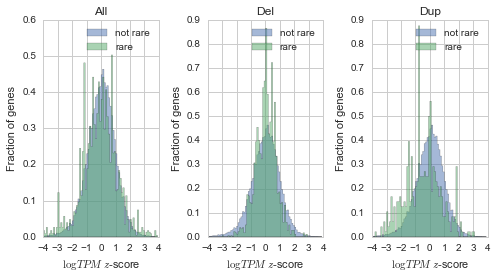

In [ ]:
fig,axs = plt.subplots(1, 3, figsize=(7, 4))
ax = axs[0]
cnv_not_rare.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='not rare', ax=ax)
cnv_rare.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='rare', ax=ax)
ax.legend()
ax.set_ylabel('Fraction of genes')
ax.set_xlabel('$\log TPM$ $z$-score')
ax.set_title('All')

ax = axs[1]
cnv_not_rare.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='not rare', ax=ax)
cnv_rare_less.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='rare', ax=ax)
ax.legend()
ax.set_ylabel('Fraction of genes')
ax.set_xlabel('$\log TPM$ $z$-score');
ax.set_title('Del')

ax = axs[2]
cnv_not_rare.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='not rare', ax=ax)
cnv_rare_greater.hist(bins=np.arange(-4, 4, 0.1), normed=True, alpha=0.5, histtype='stepfilled', label='rare', ax=ax)
ax.legend()
ax.set_ylabel('Fraction of genes')
ax.set_xlabel('$\log TPM$ $z$-score')
ax.set_title('Dup')

fig.tight_layout()
fig.savefig(os.path.join(outdir, 'rare_cnv_hists.pdf'))

In [ ]:
cnv_rare = []
cnv_rare_less = []
cnv_rare_greater = []
cnv_not_rare = []
for i in rare_cnv_info.index:
    se = cnv_geno.ix[i, unrelateds]
    mode = rare_cnv_info.ix[i, 'cn_mode']
    r = se[se != mode].index
    lessr = se[se < mode]
    greaterr = se[se > mode]
    nr = se[se == mode].index
    for g in set(rare_cnv_info.ix[i, 'gene_overlaps'].split(',')) & set(log_tpm_z.index):
        if greaterr.shape[0] > 0:
            if sum(log_tpm_z.ix[g, greaterr] < -2) > 0:
                print(i, g, greaterr)

('CNV_8_146276675_146279317', 'ENSG00000182307.8', f4b0146d-7508-457f-a754-bb4042583c4b    3
Name: CNV_8_146276675_146279317, dtype: int64)
('CNV_9_36273428_36278602', 'ENSG00000122705.12', 7e46a561-21f6-4340-b2e2-41ef50b7d943    3
Name: CNV_9_36273428_36278602, dtype: int64)
('CNV_7_148820780_148825437', 'ENSG00000197024.4', d5034b1e-43c1-486a-8d18-18b15f635e70    3
Name: CNV_7_148820780_148825437, dtype: int64)
('CNV_7_133582402_133604451', 'ENSG00000131558.10', 62e55d9a-4bf7-4ab1-bfc1-32b711e68dd4    3
Name: CNV_7_133582402_133604451, dtype: int64)
('CNV_7_133552783_133574111', 'ENSG00000131558.10', 62e55d9a-4bf7-4ab1-bfc1-32b711e68dd4    3
Name: CNV_7_133552783_133574111, dtype: int64)
('CNV_7_133526828_133552782', 'ENSG00000131558.10', 62e55d9a-4bf7-4ab1-bfc1-32b711e68dd4    3
Name: CNV_7_133526828_133552782, dtype: int64)
('CNV_7_133472945_133511987', 'ENSG00000131558.10', 62e55d9a-4bf7-4ab1-bfc1-32b711e68dd4    3
Name: CNV_7_133472945_133511987, dtype: int64)
('CNV_7_133425056_1

In [ ]:
gene_info.ix['ENSG00000122705.12']

gene_name                CLTA
gene_type      protein_coding
chrom                    chr9
start                36190852
end                  36304778
strand                      +
gene_status             KNOWN
source                 HAVANA
level                       1
Name: ENSG00000122705.12, dtype: object

In [ ]:
cnv_rare_greater.head()

AttributeError: 'list' object has no attribute 'head'

In [ ]:
tt = log_tpm_z.apply(lambda x: stats.mstats.normaltest(x)[1], axis=1)

In [ ]:
tt.hist()

In [ ]:
?fisher_exact